# Principle Component Analysis of US States by Demographic Charateristics

## Import Packages

In [17]:
import pandas as pd
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler
import math
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import collections as mc
import sklearn

## Import Data

In [2]:
states = pd.read_csv('../input/state_abbreviations.csv')
demographics = pd.read_csv('../input/state_demographics.csv')
gun_ownership = pd.read_csv('../input/gun_ownership.csv')
obesity = pd.read_csv('../input/obesity_statistics.csv')
unemployment = pd.read_csv('../input/unemployment_statistics.csv')
election_results_2012 = pd.read_csv('../input/election_results_2012.csv')
election_results_2016 = pd.read_csv('../input/election_results_2016.csv')
election_polls_2016 = pd.read_csv('../input/election_polls_2016.csv')

## Pre-processing and Functions

In [3]:
df = pd.merge(states, demographics, on = 'state')
df = pd.merge(df, gun_ownership, on = 'state')
df = pd.merge(df, obesity, on = 'state')
df = pd.merge(df, unemployment, on = 'state')
df = pd.merge(df, election_results_2012, on = 'state')
df = pd.merge(df, election_results_2016, on = 'state')
df = pd.merge(df, election_polls_2016, on = 'state')

In [4]:
df['winner_2012'] = np.where(df['pct_obama_2012']>df['pct_romney_2012'], "D", "R")
df['winner_2016'] = np.where(df['pct_clinton_2016']>df['pct_trump_2016'], "D", "R")
df['poll_error_trump_2016'] = df['pct_trump_2016'] - df['poll_trump_2016']

In [102]:
swing_states = ['Arizona', 'Colorado', 'Florida', 'Georgia', 'Iowa', 'Michigan', 'Minnesota', 'Nevada', 'NewHampshire'
                , 'NewMexico', 'NorthCarolina', 'Ohio', 'Pennsylvania', 'Virginia', 'Wisconsin']
pca_vars = ['age_18_29', 'age_30_44', 'age_45_64', 'age_Over65', 'white', 'african_american', 'latino'
            , 'poverty_rate', 'hh_income_over100k_rate', 'unemployment_rate'
            , 'college_educated_rate', 'gun_ownership_rate', 'adult_obesity_rate']
proj_vars = ['pct_clinton_2016', 'pct_trump_2016', 'poll_error_trump_2016', 'pct_obama_2012', 'pct_romney_2012']
info_vars = ['state', 'abbreviation', 'winner_2012', 'winner_2016', 'poll_error_trump_2016']

In [103]:
def data_processing(df):
    X = df[pca_vars]
    info = df[info_vars]
    return X, info

In [104]:
def pca_analysis(X, components = 2):
    X_std = StandardScaler().fit_transform(X)
    sklearn_pca = sklearnPCA(n_components = components)
    c_alpha = sklearn_pca.fit_transform(X_std)
    d_alpha = sklearn_pca.transform(np.eye(len(pca_vars)))
    return c_alpha, d_alpha

In [105]:
def pca_plot(pca_x, pca_y, vars_x, vars_y, lines, color, name, axes = [1,2]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (26,13))
    
    ax1.scatter(pca_x, pca_y, c = color)
    ax1.scatter(vars_x, vars_y, c = 'black', marker = 'x') 
    lc = mc.LineCollection(lines, colors='black', linewidths=2)
    ax1.add_collection(lc)
    for i, txt in enumerate(pca_vars):
        ax1.annotate(txt, (vars_x[i], vars_y[i]), fontsize = 15, color = 'black');
    ax1.set_xlabel('PCA Axis {}'.format(axes[0]), fontsize = 20)
    ax1.set_ylabel('PCA Axis {}'.format(axes[1]), fontsize = 20)
    
    ax2.scatter(vars_x, vars_y, c = 'grey', marker = 'x')
    for i, txt in enumerate(pca_vars):
        ax2.annotate(txt, (vars_x[i], vars_y[i]), fontsize = 13, color = 'grey');
    lc = mc.LineCollection(lines, colors='grey', linewidths=2)
    ax2.add_collection(lc)
    ax2.scatter(pca_x, pca_y, c = color)
    for i, txt in enumerate(name):
        ax2.annotate(txt, (pca_x[i], pca_y[i]), fontsize = 15, color = 'black');
    ax2.set_xlabel('PCA Axis {}'.format(axes[0]), fontsize = 20)
    ax2.set_ylabel('PCA Axis {}'.format(axes[1]), fontsize = 20)
    
    fig.suptitle('Principal Component Analysis of US States', fontsize=35)

In [106]:
def votes_plot(c_alpha, d_alpha, info, scale_factor = 1):
    pca_x = c_alpha[:,0]
    pca_y = c_alpha[:,1]
    vars_x = scale_factor*d_alpha[:,0]
    vars_y = scale_factor*d_alpha[:,1]
    lines = []
    for i in range(len(pca_vars)):
        lines.append([(0, 0), (scale_factor*d_alpha[:,0][i], scale_factor*d_alpha[:,1][i])])

    color = np.where(info['winner_2016'] == 'R', 'red', 'blue')
    name = info['abbreviation']
    
    pca_plot(pca_x, pca_y, vars_x, vars_y, lines, color, name)

In [107]:
def poll_plot(c_alpha, d_alpha, info, scale_factor = 1):
    pca_x = c_alpha[:,1]
    pca_y = c_alpha[:,2]
    vars_x = scale_factor*d_alpha[:,1]
    vars_y = scale_factor*d_alpha[:,2]
    lines = []
    for i in range(len(pca_vars)):
        lines.append([(0, 0), (scale_factor*d_alpha[:,1][i], scale_factor*d_alpha[:,2][i])])

    color = info['poll_error_trump_2016']
    name = info['abbreviation']
    
    pca_plot(pca_x, pca_y, vars_x, vars_y, lines, color, name, axes = [2,3])

In [147]:
def k_means(X, k, info):
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(X)
    labels = kmeans.predict(X)
    C = kmeans.cluster_centers_
    

    name = info['abbreviation']
    markers = np.where(info['winner_2016']=='R', '+', 'x')
    color_scale = ['g', 'y', 'purple', 'brown']
    colors = labels.apply(lambda x: color_scale[x])
    fig, ax = plt.subplots(figsize = (10,10))
    for x, y, c, m in zip(X[:,0], X[:,1], colors, markers):
        ax.scatter(x, y, c = c, marker=m)
    ax.scatter(C[:,0], C[:,1], marker = '*', c = '#050505', s = 500)
    for i, txt in enumerate(name):
        ax.annotate(txt, (X[:,0][i], X[:,1][i]), fontsize = 10, color = 'black');

In [159]:
color_scale = ['g', 'y', 'purple', 'brown']
test = pd.DataFrame(labels)

## USA Analysis

In [143]:
data = df[df['abbreviation']!="DC"].reset_index(drop = True)

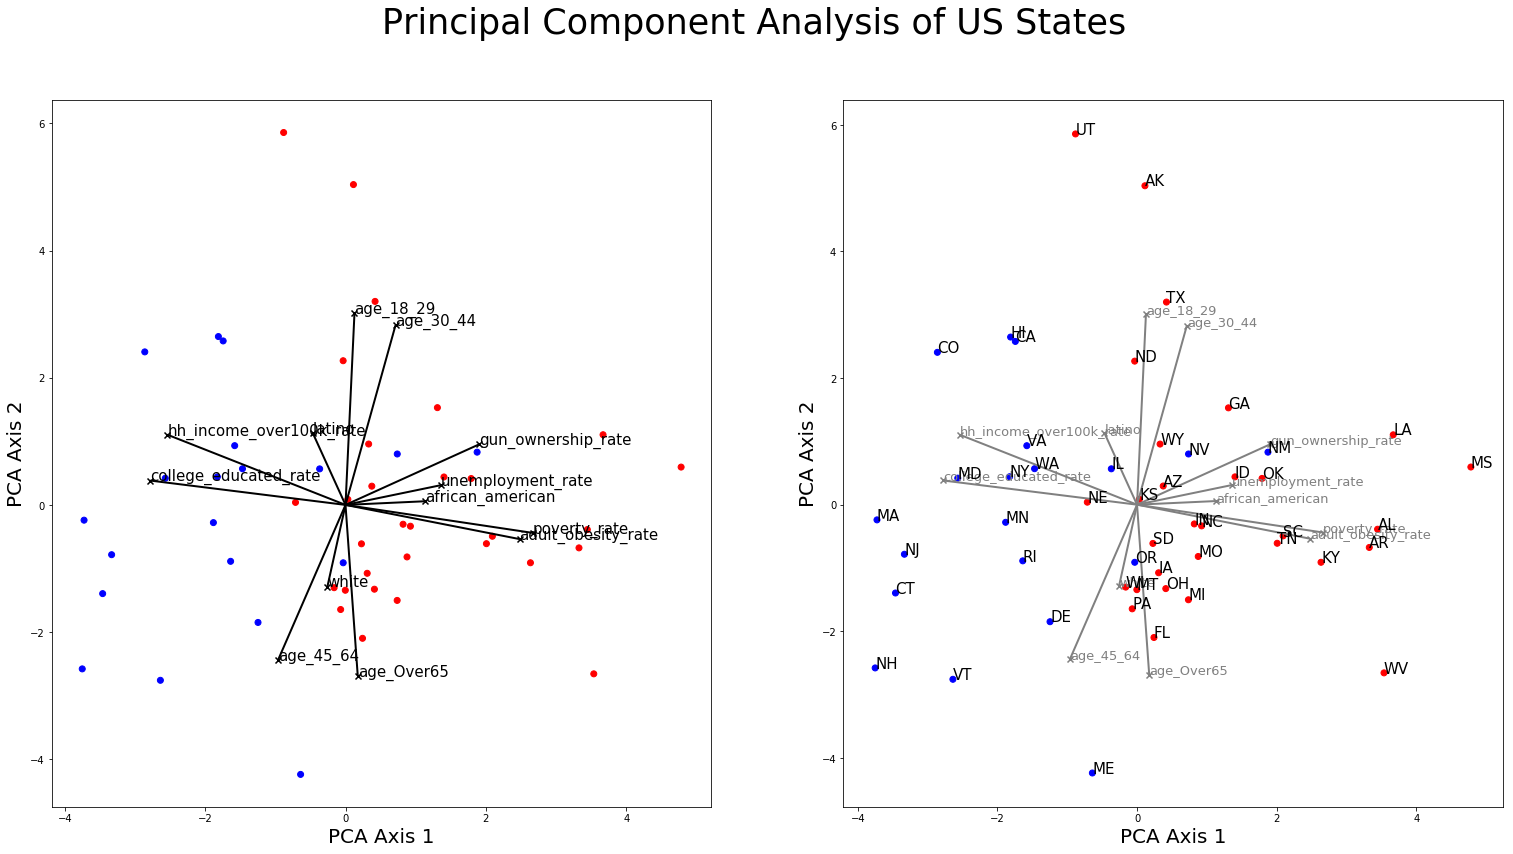

In [144]:
X = data_processing(data)[0]
info = data_processing(data)[1]
c_alpha = pca_analysis(X)[0]
d_alpha = pca_analysis(X)[1]
votes_plot(c_alpha, d_alpha, info, scale_factor=6)

### K-Means Clustering on PCA Axes 1 and 2

In [148]:
k_means(c_alpha, 2, info)

AttributeError: 'numpy.ndarray' object has no attribute 'apply'

## Swing State Analysis

In [112]:
data = df[df['state'].apply(lambda x: x in swing_states)].reset_index(drop = True)

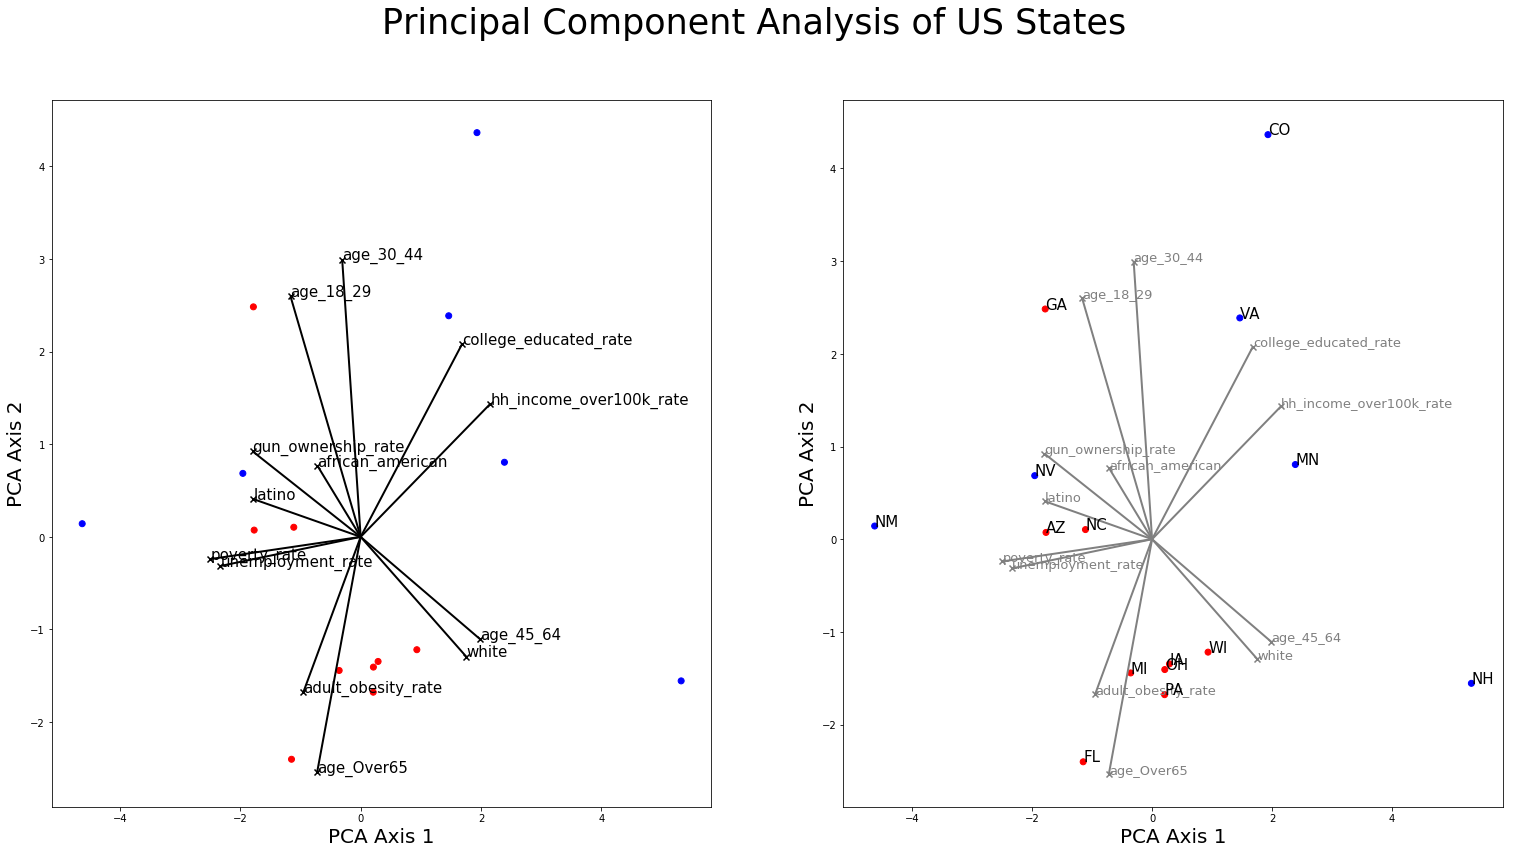

In [113]:
X = data_processing(data)[0]
info = data_processing(data)[1]
c_alpha = pca_analysis(X)[0]
d_alpha = pca_analysis(X)[1]
votes_plot(c_alpha, d_alpha, info, scale_factor=6)

### K-Means Clustering on PCA Axes 1 and 2

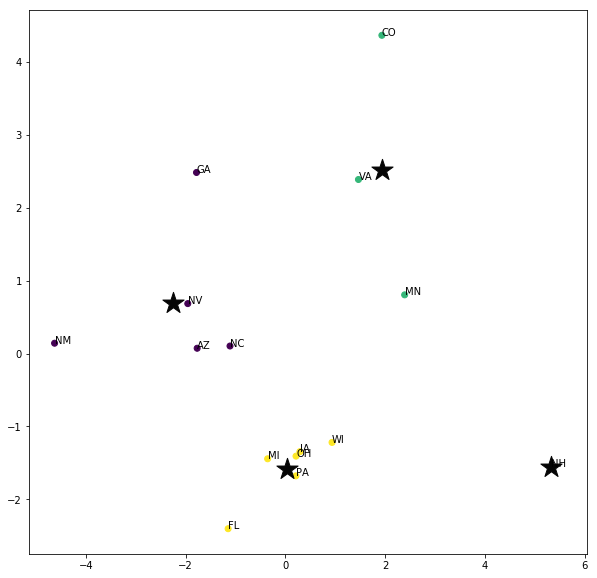

In [114]:
k_means(c_alpha, 4, info)

## Polling Error Analysis

In [69]:
data = df[df['state'].apply(lambda x: x in swing_states)].reset_index(drop = True)

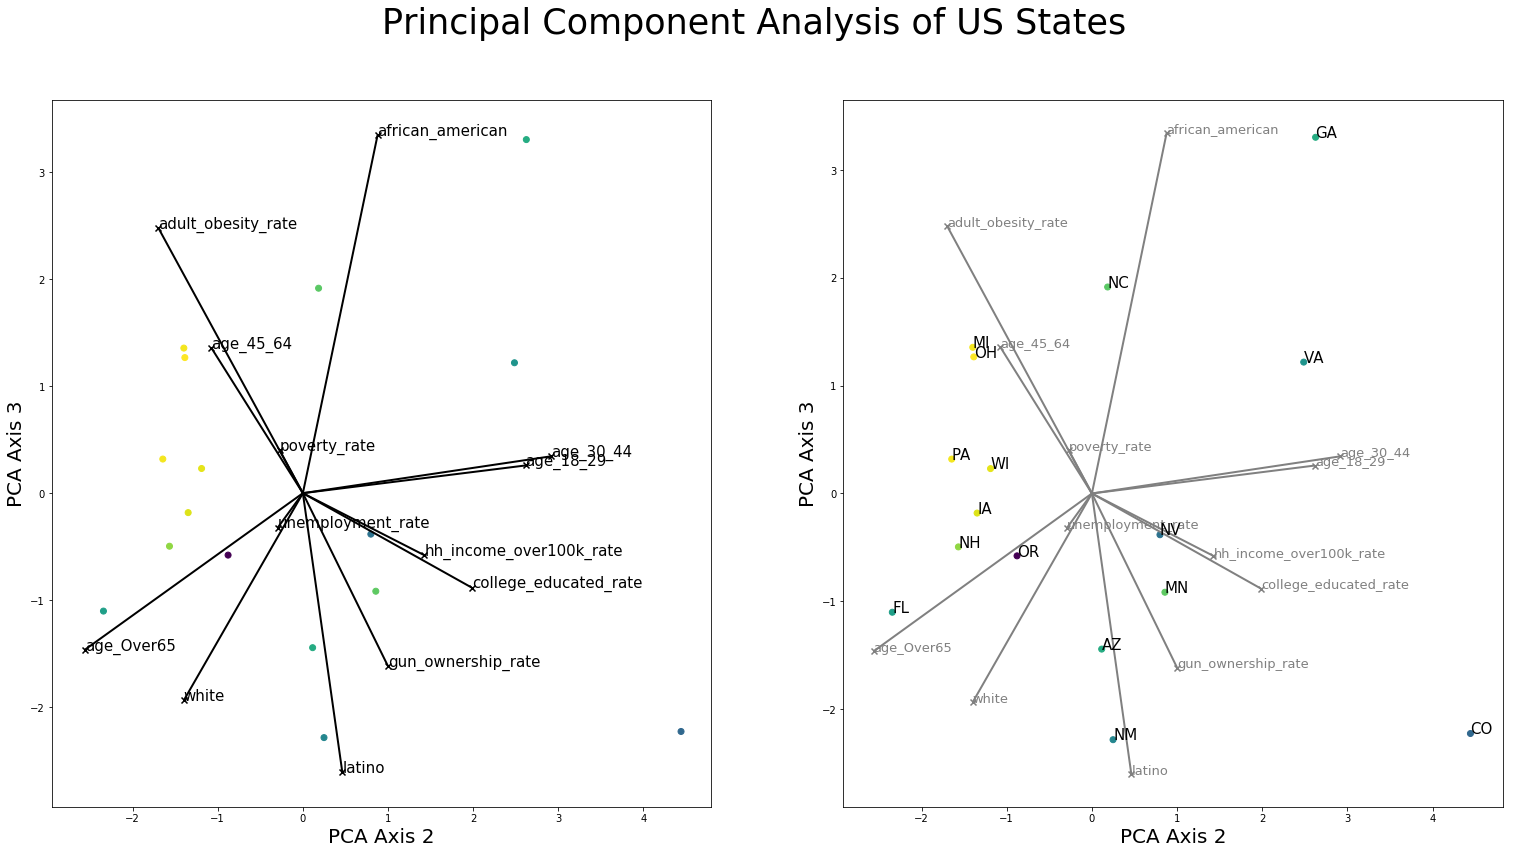

In [70]:
X = data_processing(data)[0]
info = data_processing(data)[1]
c_alpha = pca_analysis(X, components=3)[0]
d_alpha = pca_analysis(X, components=3)[1]
poll_plot(c_alpha, d_alpha, info, scale_factor=6)

In yellow, the states where Trump most outperformed his polls (MI, OH, PA). In blue, the states where he most underperformed his polls. The polling error in Trump's favor is strongly correlated with with high adult obesity rates, high African-American population, and low latino population.